In [1]:
from pprint import pprint

In [2]:
import convex as cx

In [3]:
import spacy
nlp = spacy.load("en_core_web_lg")

In [165]:
questions = [ 
    "Which actor voiced the Unicorn in The Last Unicorn?",
    "And Alan Arkin was behind...?",
    "And Alan Arkin be behind...? Why How when which was happy make fun",
    "Who is the composer of the soundtrack?",
    "So who performed the songs?",
    "Genre of this band's music?",
    "By the way, who was the director?"
            ]

In [28]:
import time
import json
import requests

def tagme_entities(to_tag):
    request_successfull = False
    print(to_tag)
    while not request_successfull:
        try:
            results = json.loads(requests.get('https://tagme.d4science.org/tagme/tag?lang=en&gcube-token=' + cx.tagmeToken + '&text=' + to_tag).content)
            request_successfull = True
        except:
            print("Error: Did you put your tagMe_token in the settings file?")
            print(to_tag)
            time.sleep(5)
    return results

In [5]:
def get_chunked(to_chunk):
    doc = nlp(to_chunk)
    return [chunk.text for chunk in doc.noun_chunks]

In [29]:
def get_entities(sentence):
    chunked = get_chunked(sentence)
    tagged = tagme_entities(to_tag)
    entities = []
    print(tagged)
    for tag in tagged["annotations"]:
        try:
            wikidata_ids = cx.wd.name_to_wikidata_ids(tag['title'])
        except:
            continue
        for wikidata_id in wikidata_ids:
            entities.append({'title': tag['title'], 'spot': tag['spot'], 'link_probability': tag['link_probability'], 'wikidata_id': wikidata_id})
    return entities

In [44]:
import time
import json
import requests

def predicate_to_wikidata_ids(name, top_k_limit=3):
    name = name.split('(')[0]

    request_successfull = False
    while not request_successfull:
        try:
            entity_ids = requests.get('https://www.wikidata.org/w/api.php?action=wbsearchentities&format=json&language=en&type=property&limit=' + str(top_k_limit) + '&search='+name).json()
            request_successfull = True
        except:
            time.sleep(5)
    results = entity_ids.get("search")
    if not results:
        return ""
    if not len(results):
        return ""
    res = []
    for result in results:
        res.append(result['id'])
    return res

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

colors_dict = {'predicate': 'red',
               'entity': 'yellow'}

# Building labels for graph
def get_labels_from_graph(graph):
    labels = dict()
    node_names = [n for n in graph.nodes()]
    for i, node in enumerate(node_names):
        position = node.find("-")
        if position >= 0:
            node_src = node
            node = node[:position]
            node_names[i] = node[:position]
            labels[node_src] = str(cx.wd.wikidata_id_to_label(node))
        else:
            labels[node] = str(cx.wd.wikidata_id_to_label(node))
    return labels

# Plotting the graph
def plot_graph(graph, name, title="Graph"):
    fig = plt.figure(figsize=(10,10))
    ax = plt.subplot(111)
    ax.set_title(str("answer: "+title), fontsize=10)
    pos = nx.spring_layout(graph)
    nx.draw(graph, pos, node_size=50, node_color='yellow', font_size=10, font_weight='bold', with_labels=True, labels=get_labels_from_graph(graph))
    plt.tight_layout()
    plt.savefig(str(name)+".png", format="PNG")
    plt.show()

In [56]:
[get_chunked(q) for q in questions]

[['Which actor', 'the Unicorn', 'The Last Unicorn'],
 ['Alan Arkin'],
 ['Who', 'the composer', 'the soundtrack'],
 ['who', 'the songs'],
 ['Genre', "this band's music"],
 ['the way', 'who', 'the director']]

In [94]:
def get_sub_sentences(question):
    doc = nlp(question)

    chunked = [chunk.text for chunk in doc.noun_chunks]
    chunked_ids = [cx.wd.name_to_wikidata_ids(chunk) for chunk in chunked]

    main_themes = []
    theme_complement = []
    for i, theme in enumerate(chunked_ids):
        if theme != "": main_themes.append(theme)
        else: theme_complement.append(chunked[i])
    
    return doc, chunked, main_themes, theme_complement

In [166]:
sub_sentences = [get_sub_sentences(q) for q in questions]
sub_sentences[0]

(Which actor voiced the Unicorn in The Last Unicorn?,
 ['Which actor', 'the Unicorn', 'The Last Unicorn'],
 [['Q14834367', 'Q22278930', 'Q65070436'], ['Q176198', 'Q967268', 'Q7746145']],
 ['Which actor'])

In [100]:
[(token.text,token.head, token.tag_, token.pos_) for token in sub_sentences[2][0]]

[('And', be, 'CC', 'CCONJ'),
 ('Alan', Arkin, 'NNP', 'PROPN'),
 ('Arkin', be, 'NNP', 'PROPN'),
 ('be', be, 'VBP', 'VERB'),
 ('behind', be, 'RB', 'ADV'),
 ('...', be, 'NFP', 'PUNCT'),
 ('?', be, '.', 'PUNCT')]

In [168]:
def get_predicates_from_sentence(sentence, top_k=3):
    #print("sentence: ", sentence)
    predicates = [(token) for token in sentence if token.pos_ == "VERB" or token.pos_ == "AUX"]
    #print("predicates: ",predicates)
    
    if predicates:
        predicates_ids = list(set(predicate_to_wikidata_ids(predicates[0].text, top_k)))
        print([(predicate, cx.wd.wikidata_id_to_label(predicate)) for predicate in predicates_ids])
    
    return predicates

In [169]:
#predicates_for_sub_sentences = []
predicates_ids = [get_predicates_from_sentence(s[0]) for s in sub_sentences]
predicates_ids

[('P725', 'voice actor')]
[('P1196', 'manner of death'), ('P641', 'sport'), ('P31', 'instance of')]
[('P580', 'start date'), ('P1001', 'applies to jurisdiction'), ('P155', 'follows')]
[('P131', 'is in the administrative unit'), ('P31', 'instance of'), ('P433', 'issue')]
[]
[('P1196', 'manner of death'), ('P641', 'sport'), ('P31', 'instance of')]


[[voiced], [was], [be, was, make], [is], [performed], [], [was]]

In [115]:
[[t for t in s[0]] for s in sub_sentences]

[[Which, actor, voiced, the, Unicorn, in, The, Last, Unicorn, ?],
 [And, Alan, Arkin, was, behind, ..., ?],
 [And, Alan, Arkin, be, behind, ..., ?],
 [Who, is, the, composer, of, the, soundtrack, ?],
 [So, who, performed, the, songs, ?],
 [Genre, of, this, band, 's, music, ?],
 [By, the, way, ,, who, was, the, director, ?]]

In [153]:
interogrative_dets = [[t for t in s[0] if t.tag_ == "WDT" or t.tag_ == "WP" or t.tag_ == "WP$" or t.tag_ == "WRB"] for s in sub_sentences]
interogrative_dets

[[Which], [], [Why, How, when, which], [Who], [who], [], [who]]

In [155]:
[d.head for d in interogrative_dets[2] if d]

[Why, when, Why, when]

In [158]:
interogative_noun = [noun.head for noun in interogrative_dets[2]]
interogative_noun

[Why, when, Why, when]

In [171]:


related_noun_to_predicate = [noun for noun in doc if noun.head == predicates_ids and noun != interogative_noun[0] and (noun.pos_ == "NOUN" or noun.pos_ == "PROPN")]
related_noun_to_predicate

TypeError: Argument 'other' has incorrect type (expected spacy.tokens.token.Token, got list)

In [214]:
# interogative_noun -> predicates -> related_noun_to_predicate -> main_themes
related_noun_to_predicate_id = cx.wd.name_to_wikidata_ids(related_noun_to_predicate[0].text)
related_noun_to_predicate_id

['Q7246', 'Q1565614', 'Q20983877']

In [433]:
def get_best_statement_from_chunks_with_qualifiers(chunked_ids, to_find, qualifier_type):
    highest_matching_similarity = -1
    best_statement = ""
    
    for chunk in chunked_ids:
        for c in chunk:
            if cx.wd.wikidata_id_to_label(c) != None:
                statements = cx.wd.get_all_statements_of_entity(c)
                #print(statements)
                for statement in statements:
                    if statement.get('qualifiers'):
                        for qualifier in statement['qualifiers']:
                            matching_similarity = cx.spacy.similarity_word2vec(to_find, cx.wd.wikidata_id_to_label(qualifier[qualifier_type]['id']))
                            if highest_matching_similarity == -1 or matching_similarity > highest_matching_similarity:
                                highest_matching_similarity = matching_similarity
                                best_statement = statement

    return highest_matching_similarity, best_statement

In [434]:
def get_best_statement_from_chunks(chunked_ids, to_find, statement_type):
    highest_matching_similarity = -1
    best_statement = ""

    for chunk in chunked_ids:
        for c in chunk:
            if cx.wd.wikidata_id_to_label(c) != None:
                statements = cx.wd.get_all_statements_of_entity(c)
                for statement in statements:
                    matching_similarity = cx.spacy.similarity_word2vec(to_find, cx.wd.wikidata_id_to_label(statement[statement_type]['id']))
                    if highest_matching_similarity == -1 or matching_similarity > highest_matching_similarity:
                        highest_matching_similarity = matching_similarity
                        best_statement = statement
    
    return highest_matching_similarity, best_statement

In [526]:
predicates = [cx.wd.wikidata_id_to_label(p) for p in predicates_id]
noun_to_predicates = [cx.wd.wikidata_id_to_label(n) for n in related_noun_to_predicate_id]
main_topics = [item for sublist in main_themes for item in sublist]

In [532]:
to_run = predicates + chunked + noun_to_predicates + main_topics
best_statements = []

for r in to_run:
    best_statements.append(get_best_statement_from_chunks_with_qualifiers(chunked_ids, r, "qualifier_predicate"))
    best_statements.append(get_best_statement_from_chunks_with_qualifiers(chunked_ids, r, "qualifier_object"))
    best_statements.append(get_best_statement_from_chunks(chunked_ids, r, "predicate"))
    best_statements.append(get_best_statement_from_chunks(chunked_ids, r, "object"))

best_statements_filtered = []
[best_statements_filtered.append(s) for s in sorted(best_statements, key=lambda x: x[0], reverse=True) if s[0]>0 and s[1] not in [e[1] for e in best_statements_filtered]]
best_statements_filtered

[(1.0,
  {'entity': {'id': 'Q176198'},
   'predicate': {'id': 'P725'},
   'object': {'id': 'Q202725'}}),
 (1.0,
  {'entity': {'id': 'Q176198'},
   'predicate': {'id': 'P144'},
   'object': {'id': 'Q967268'}}),
 (0.6838807705173462,
  {'entity': {'id': 'Q176198'},
   'predicate': {'id': 'P725'},
   'object': {'id': 'Q3090544'},
   'qualifiers': [{'qualifier_predicate': {'id': 'P453'},
     'qualifier_object': {'id': 'Q30060811'}}]}),
 (0.6485193941397088,
  {'entity': {'id': 'Q176198'},
   'predicate': {'id': 'P136'},
   'object': {'id': 'Q28968511'},
   'qualifiers': []}),
 (0.633362753908819,
  {'entity': {'id': 'Q176198'},
   'predicate': {'id': 'P1877'},
   'object': {'id': 'Q285007'},
   'qualifiers': []}),
 (0.5881755381030452,
  {'entity': {'id': 'Q14834367'},
   'predicate': {'id': 'P54'},
   'object': {'id': 'Q54930'},
   'qualifiers': [{'qualifier_predicate': {'id': 'P580'},
     'qualifier_object': {'id': '2012-01-01T00:00:00Z'}},
    {'qualifier_predicate': {'id': 'P582'},
 

In [533]:
from copy import copy

best_statements_to_graph = []

for statement in best_statements_filtered:
    tmp_statement = copy(statement[1])
    
    if statement[1].get('qualifiers'):
        for q in tmp_statement['qualifiers']:
            qualifier_statement = {'entity': {'id': tmp_statement['entity']['id']}}
            qualifier_statement['predicate'] = {'id': q['qualifier_predicate']['id']}
            qualifier_statement['object'] = {'id': q['qualifier_object']['id']}
            best_statements_to_graph.append(qualifier_statement)
        del(tmp_statement['qualifiers'])
        
    best_statements_to_graph.append(tmp_statement)
    

best_statements_to_graph

[{'entity': {'id': 'Q176198'},
  'predicate': {'id': 'P725'},
  'object': {'id': 'Q202725'}},
 {'entity': {'id': 'Q176198'},
  'predicate': {'id': 'P144'},
  'object': {'id': 'Q967268'}},
 {'entity': {'id': 'Q176198'},
  'predicate': {'id': 'P453'},
  'object': {'id': 'Q30060811'}},
 {'entity': {'id': 'Q176198'},
  'predicate': {'id': 'P725'},
  'object': {'id': 'Q3090544'}},
 {'entity': {'id': 'Q176198'},
  'predicate': {'id': 'P136'},
  'object': {'id': 'Q28968511'},
  'qualifiers': []},
 {'entity': {'id': 'Q176198'},
  'predicate': {'id': 'P1877'},
  'object': {'id': 'Q285007'},
  'qualifiers': []},
 {'entity': {'id': 'Q14834367'},
  'predicate': {'id': 'P580'},
  'object': {'id': '2012-01-01T00:00:00Z'}},
 {'entity': {'id': 'Q14834367'},
  'predicate': {'id': 'P582'},
  'object': {'id': '2015-01-01T00:00:00Z'}},
 {'entity': {'id': 'Q14834367'},
  'predicate': {'id': 'P54'},
  'object': {'id': 'Q54930'}},
 {'entity': {'id': 'Q176198'},
  'predicate': {'id': 'P31'},
  'object': {'id'

In [642]:
def get_best_statements_filtered(chunked_ids, ro_run):
    best_statements = []

    for r in to_run:
        best_statements.append(get_best_statement_from_chunks_with_qualifiers(chunked_ids, r, "qualifier_predicate"))
        best_statements.append(get_best_statement_from_chunks_with_qualifiers(chunked_ids, r, "qualifier_object"))
        best_statements.append(get_best_statement_from_chunks(chunked_ids, r, "predicate"))
        best_statements.append(get_best_statement_from_chunks(chunked_ids, r, "object"))

    best_statements_filtered = []
    [best_statements_filtered.append(s) for s in sorted(best_statements, key=lambda x: x[0], reverse=True) if s[0]>0 and s[1] not in [e[1] for e in best_statements_filtered]]
    return best_statements_filtered

In [644]:
chunked_ids

['',
 ['Q14834367', 'Q22278930', 'Q65070436'],
 ['Q176198', 'Q967268', 'Q7746145']]

In [ ]:
cx.wd.get_all_statements_of_entity()

In [757]:
from copy import copy

def statements_to_graph(statements):
    best_statements_to_graph = []

    for statement in statements:
        tmp_statement = copy(statement)
        
        if tmp_statement.get('qualifiers'):
            for q in tmp_statement['qualifiers']:
                qualifier_statement = {'entity': {'id': tmp_statement['entity']['id']}}
                qualifier_statement['predicate'] = {'id': q['qualifier_predicate']['id']}
                qualifier_statement['object'] = {'id': q['qualifier_object']['id']}
                best_statements_to_graph.append(qualifier_statement)
            del(tmp_statement['qualifiers'])
        else: 
            if ('qualifiers' in tmp_statement): del(tmp_statement['qualifiers'])

        best_statements_to_graph.append(tmp_statement)

    return best_statements_to_graph

In [807]:
def get_statements_from_predicate(statements):
    predicated_statements = []
    for s in statements:
        if s["entity"]["id"] in [p for p in main_topics]:
            predicated_statements += cx.wd.get_all_statements_of_entity(s["entity"]["id"])

    return [t for t in predicated_statements if t['predicate']['id'] == predicates_id[0]]


test = statements_to_graph(get_statements_from_predicate(best_statements_to_graph))

In [774]:
predicates_id[0]

'P725'

In [795]:
[p for p in main_topics]

['Q14834367', 'Q22278930', 'Q65070436', 'Q176198', 'Q967268', 'Q7746145']

In [673]:
main_topics

['Q14834367', 'Q22278930', 'Q65070436', 'Q176198', 'Q967268', 'Q7746145']

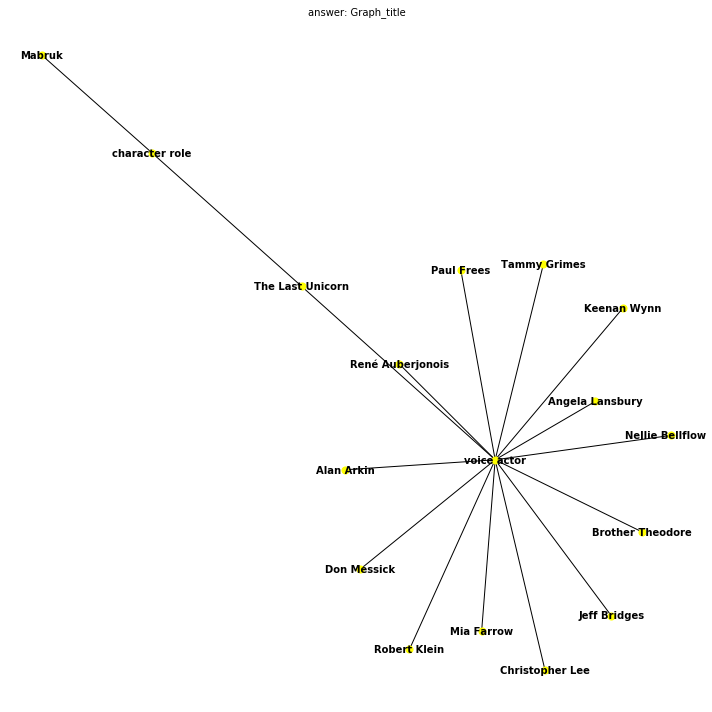

In [808]:
import networkx as nx

graph = nx.Graph()
turn = 1
predicate_nodes = {}

for statement in test:
    if not statement['entity']['id'] in graph:
        graph.add_node(statement['entity']['id'], type='entity', turn=turn)
    if not statement['object']['id'] in graph:
        graph.add_node(statement['object']['id'], type='entity', turn=turn)
    
    # get current index of predicate used
    if not predicate_nodes.get(statement['predicate']['id']):
        predicate_nodes_index = 0
        predicate_nodes[statement['predicate']['id']] = 0
    else:
        # the predicate already occured => fetch the next index available and increase the saved one
        predicate_index = predicate_nodes[statement['predicate']['id']]
        predicate_nodes[statement['predicate']['id']] += 1

    # add the predicate node
    predicate_node_id = (statement['predicate']['id'] + "-" + str(predicate_index))
    graph.add_node(predicate_node_id, type='predicate', turn=turn)
    
    # add the two edges (entity->predicate->object)
    graph.add_edge(statement['entity']['id'], predicate_node_id)
    graph.add_edge(predicate_node_id, statement['object']['id'])
    
plot_graph(graph, "file_name_graph", "Graph_title")

In [571]:
#graph.degree()
max(dict(graph.degree()).items(), key = lambda x : x[1])

('Q176198', 8)

In [611]:
[graph.edges(e + "-" + str(0)) for e in predicates_id]

[EdgeDataView([('P725-0', 'Q176198'), ('P725-0', 'Q202725'), ('P725-0', 'Q3090544')])]

In [620]:
[p for p in predicates_id][0]

'P725'

In [631]:
verb_related_nodes = [e for e in list(graph.edges) if e[0].find([p for p in predicates_id][0])==False or e[1].find([p for p in predicates_id][0])==False]
verb_related_nodes

[('Q176198', 'P725-0'), ('Q202725', 'P725-0'), ('P725-0', 'Q3090544')]

In [633]:
for entity in verb_related_nodes:
    

<function tuple.index(value, start=0, stop=9223372036854775807, /)>

In [71]:
# remove all unnecessary words of the question to avoid noise in the similarity-computation
def shorten_question_for_predicate_similarity(question, entity_spot):
    # remove the spot of the entity
    question = question.replace(entity_spot, "")
    # remove symbols
    question = question.replace(',', '').replace('!', '').replace('?', '').replace('.', '').replace("'", '').replace('"', '').replace(':','').replace('’', '')
    # expand the question by whitespaces to be able to find the stopwords
    question = (" " + question + " ").lower()
    # remove stopwords
    for stopword in cx.string.stopwords:
        question = question.replace(" "+stopword+" ", " ")
    # replace w words, but still keep the information in the question
    question = question.replace(" where ", " location ")
    question = question.replace(" wheres ", " location ")
    question = question.replace(" when ", " date ")
    question = question.replace(" whens ", " date ")
    question = question.replace(" who ", " person ")
    question = question.replace(" whos ", " person ")
    question = question.replace(" why ", " cause ")
    question = question.replace(" whys ", " cause ")
    # wikidata does not give the accuracy of the date (year, month, ...)
    question = question.replace('year', 'date')
    # remove remaining s from plural or possesive expressions
    question = question.replace(' s ', ' ')
    # remove whitespaces
    while "  " in question:
        question = question.replace("  ", " ")
    return question.strip()

In [72]:
shorten_question_for_predicate_similarity(chunked[2], "lol")

'last unicorn'

# Build Graph

In [ ]:
import networkx as nx
def build_graph(context, statements, turn = 1, qa=False):
    if not context:
        context = nx.Graph()

    # print statements
    for statement in statements:
        # add the entity and object node
        if not statement['entity']['id'] in context:
            context.add_node(statement['entity']['id'], type='entity', turn=turn, qa=qa)
        if not statement['object']['id'] in context:
            context.add_node(statement['object']['id'], type='entity', turn=turn, qa=qa)

        # get current index of predicate used
        if not cx.gp.predicate_nodes.get(statement['predicate']['id']):
            # the predicate did not occur yet => index 0 and new entry
            cx.gp.predicate_nodes[statement['predicate']['id']] = 1
            predicate_index = 0
        else:
            # the predicate already occured => fetch the next index available and increase the saved one
            predicate_index = cx.gp.predicate_nodes[statement['predicate']['id']]
            cx.gp.predicate_nodes[statement['predicate']['id']] += 1

        # add the predicate node
        predicate_node_id = (statement['predicate']['id'] + "-" + str(predicate_index))
        context.add_node(predicate_node_id, type='predicate', turn=turn)

        # add the two edges (entity->predicate->object)
        context.add_edge(statement['entity']['id'], predicate_node_id)
        context.add_edge(predicate_node_id, statement['object']['id'])

        # if there were qualifiers occuring in the statement
        if statement.get('qualifiers'):
            for qualifier_statement in statement['qualifiers']:
                # add the qualifier_statment object
                if not qualifier_statement['qualifier_object']['id'] in context:
                    context.add_node(qualifier_statement['qualifier_object']['id'], type='entity', turn=turn, qa=qa)

                # get current index of qualifier_predicate used
                if not qualifier_predicate_nodes.get(qualifier_statement['qualifier_predicate']['id']):
                    # the qualifier_predicate did not occur yet => index 0 and new entry
                    qualifier_predicate_nodes[qualifier_statement['qualifier_predicate']['id']] = 1
                    predicate_index = 0
                else:
                    # the qualifier_predicate already occured => fetch the next index available and increase the saved one
                    predicate_index = qualifier_predicate_nodes[qualifier_statement['qualifier_predicate']['id']]
                    qualifier_predicate_nodes[qualifier_statement['qualifier_predicate']['id']] += 1

                # add the qualifier_predicate
                qualifier_predicate_node_id = qualifier_statement['qualifier_predicate']['id'] + "-" + str(predicate_index)
                context.add_node(qualifier_predicate_node_id, type='qualifier_predicate', turn=turn)

                # add the two edges (qualifier_entity->qualifier_predicate->qualifier_object)
                context.add_edge(predicate_node_id, qualifier_predicate_node_id)
                context.add_edge(qualifier_predicate_node_id, qualifier_statement['qualifier_object']['id'])
    return context

In [ ]:
turn = 1
highest_matching_similarity = -1

for entity in entities:
    result = {}
    shortened_question = shorten_question_for_predicate_similarity(question, entity['spot'])
    statements = cx.wd.get_all_statements_of_entity(entity['wikidata_id'])
    matching_similarity = ""
    for statement in statements:
        # no identifier predicates
        if statement['predicate']['id'] in cx.identifier_predicates:
            continue
        predicate_label = cx.wd.wikidata_id_to_label(statement['predicate']['id'])
        matching_similarity = cx.spacy.similarity_word2vec(predicate_label, shortened_question) * entity['link_probability']
        if highest_matching_similarity == -1 or matching_similarity > highest_matching_similarity:
            answer = statement['entity']['id'] if statement['object']['id'] == entity['wikidata_id'] else statement['object']['id']
            context = {'entity': {'id': entity['wikidata_id']}, 'predicate': {'id': statement['predicate']['id']}, 'object': {'id': answer}}
            result = {'context': context, 'answers': [{'answer': answer, 'rank': 1}] }
            highest_matching_similarity = matching_similarity
        
        print("START")
        print(statement)
        print(predicate_label)
        print(shortened_question)
        print(entity['link_probability'])
        print(matching_similarity)
        print("END")
        
    print(matching_similarity, highest_matching_similarity)
    print(entity)
    print(shortened_question)
    
    #print(statements)
    pprint(result)

In [ ]:
import networkx as nx
def expand_context_with_statements(context, statements, turn = 1, qa=False):
    if not context:
        context = nx.Graph()

    # print statements
    for statement in statements:
        # add the entity and object node
        if not statement['entity']['id'] in context:
            context.add_node(statement['entity']['id'], type='entity', turn=turn, qa=qa)
        if not statement['object']['id'] in context:
            context.add_node(statement['object']['id'], type='entity', turn=turn, qa=qa)

        # get current index of predicate used
        if not cx.gp.predicate_nodes.get(statement['predicate']['id']):
            # the predicate did not occur yet => index 0 and new entry
            cx.gp.predicate_nodes[statement['predicate']['id']] = 1
            predicate_index = 0
        else:
            # the predicate already occured => fetch the next index available and increase the saved one
            predicate_index = cx.gp.predicate_nodes[statement['predicate']['id']]
            cx.gp.predicate_nodes[statement['predicate']['id']] += 1

        # add the predicate node
        predicate_node_id = (statement['predicate']['id'] + "-" + str(predicate_index))
        context.add_node(predicate_node_id, type='predicate', turn=turn)

        # add the two edges (entity->predicate->object)
        context.add_edge(statement['entity']['id'], predicate_node_id)
        context.add_edge(predicate_node_id, statement['object']['id'])

        # if there were qualifiers occuring in the statement
        if statement.get('qualifiers'):
            for qualifier_statement in statement['qualifiers']:
                # add the qualifier_statment object
                if not qualifier_statement['qualifier_object']['id'] in context:
                    context.add_node(qualifier_statement['qualifier_object']['id'], type='entity', turn=turn, qa=qa)

                # get current index of qualifier_predicate used
                if not qualifier_predicate_nodes.get(qualifier_statement['qualifier_predicate']['id']):
                    # the qualifier_predicate did not occur yet => index 0 and new entry
                    qualifier_predicate_nodes[qualifier_statement['qualifier_predicate']['id']] = 1
                    predicate_index = 0
                else:
                    # the qualifier_predicate already occured => fetch the next index available and increase the saved one
                    predicate_index = qualifier_predicate_nodes[qualifier_statement['qualifier_predicate']['id']]
                    qualifier_predicate_nodes[qualifier_statement['qualifier_predicate']['id']] += 1

                # add the qualifier_predicate
                qualifier_predicate_node_id = qualifier_statement['qualifier_predicate']['id'] + "-" + str(predicate_index)
                context.add_node(qualifier_predicate_node_id, type='qualifier_predicate', turn=turn)

                # add the two edges (qualifier_entity->qualifier_predicate->qualifier_object)
                context.add_edge(predicate_node_id, qualifier_predicate_node_id)
                context.add_edge(qualifier_predicate_node_id, qualifier_statement['qualifier_object']['id'])
    return context

# Algo

- Chunk the sentence into potential important multi-words
    - For each chunk get ids
        - Save the nodes into potential themes
    - For each rejected chunks from idendification
        - Check if W statement
            - Identify the related query word
- Identify the predicates from sentence
    - Check heads of the predicate
        - Get the NN and NNP
    - Query predicate id with predicate + query word from wikidata live
    - Apply predicate to query

In [16]:
[(token.text,token.head, token.tag_, token.pos_, token.ent_kb_id_) for token in nlp(questions[0])]

[('Which', actor, 'WDT', 'DET', ''),
 ('actor', voiced, 'NN', 'NOUN', ''),
 ('voiced', voiced, 'VBD', 'VERB', ''),
 ('the', Unicorn, 'DT', 'DET', ''),
 ('Unicorn', voiced, 'NNP', 'PROPN', ''),
 ('in', voiced, 'IN', 'ADP', ''),
 ('The', Unicorn, 'DT', 'DET', ''),
 ('Last', Unicorn, 'JJ', 'ADJ', ''),
 ('Unicorn', in, 'NNP', 'PROPN', ''),
 ('?', voiced, '.', 'PUNCT', '')]

In [17]:
nlp2 = spacy.load("/data/users/romain.claret/tm/data2/nlp")

In [19]:
doc2 = nlp2(questions[0])

In [20]:
doc2 = nlp.get_pipe("entity_linker")(doc2)

KeyError: "[E001] No component 'entity_linker' found in pipeline. Available names: ['tagger', 'parser', 'ner']"

In [18]:
[(token.text,token.head, token.tag_, token.pos_, token.ent_kb_id_) for token in nlp2(questions[0])]

[('Which', actor, 'WDT', 'DET', ''),
 ('actor', voiced, 'NN', 'NOUN', ''),
 ('voiced', voiced, 'VBD', 'VERB', ''),
 ('the', Unicorn, 'DT', 'DET', ''),
 ('Unicorn', voiced, 'NNP', 'PROPN', ''),
 ('in', voiced, 'IN', 'ADP', ''),
 ('The', Unicorn, 'DT', 'DET', ''),
 ('Last', Unicorn, 'JJ', 'ADJ', ''),
 ('Unicorn', in, 'NNP', 'PROPN', ''),
 ('?', voiced, '.', 'PUNCT', '')]

In [21]:
from spacy.kb import KnowledgeBase

In [22]:
kb2 = KnowledgeBase()

TypeError: __init__() takes at least 1 positional argument (0 given)

In [34]:
[(e.text, e.ent_kb_id_) for e in doc2]

[('Which', ''),
 ('actor', ''),
 ('voiced', ''),
 ('the', ''),
 ('Unicorn', ''),
 ('in', ''),
 ('The', ''),
 ('Last', ''),
 ('Unicorn', ''),
 ('?', '')]

In [33]:
doc2[0].ent_kb_id_

''

In [35]:
vocab = nlp2.vocab

In [36]:
kb = KnowledgeBase(vocab=vocab, entity_vector_length=64)

In [37]:
len(kb)

0

In [ ]:
kb.load_bulk("/data/users/romain.claret/tm/data2/")

In [2]:
dir_kb = "/data/users/romain.claret/tm/data2/"
KB_FILE = "kb"
KB_MODEL_DIR = "nlp_kb"
OUTPUT_MODEL_DIR = "nlp"

nlp_dir = dir_kb + OUTPUT_MODEL_DIR
kb_path = dir_kb + KB_FILE

In [4]:
import spacy
nlp_kb = spacy.load(nlp_dir)

In [9]:
import logging
logger = logging.getLogger(__name__)
text = (
        "In The Hitchhiker's Guide to the Galaxy, written by Douglas Adams, "
        "Douglas reminds us to always bring our towel, even in China or Brazil. "
        "The main character in Doug's novel is the man Arthur Dent, "
        "but Dougledydoug doesn't write about George Washington or Homer Simpson."
    )
doc = nlp_kb(text)
logger.info(text)
for ent in doc.ents:
    logger.info(" ".join(["ent", ent.text, ent.label_, ent.kb_id_]))

In [10]:
["ent", ent.text, ent.label_, ent.kb_id_]

['ent', 'Homer Simpson', 'PERSON', 'Q7810']

In [11]:
doc.ents

(Douglas Adams,
 Douglas,
 China,
 Brazil,
 Doug,
 Arthur Dent,
 Dougledydoug,
 George Washington,
 Homer Simpson)

In [38]:
doc2 = nlp_kb("Who played against Federrer at Roland Garros")
[(ent.text, ent.label_, ent.kb_id_) for ent in doc2.ents]

[('Federrer', 'PERSON', 'NIL'), ('Roland Garros', 'ORG', 'Q207709')]

In [40]:
doc2 = nlp_kb("Who voiced Mickey Mouse")
[(ent.text, ent.label_, ent.kb_id_) for ent in doc2.ents]

[('Mickey Mouse', 'PERSON', 'Q11934')]

In [44]:
doc2 = nlp_kb("Who voiced the Unicorn in The Matrix")
[(ent.text, ent.label_, ent.kb_id_) for ent in doc2.ents]

[]